# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
#!pip install --user ipyparallel

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
import os 

Define domain:

In [4]:
mycluster = ipp.Cluster(n = 10)
rc = mycluster.start_and_connect_sync()
view = rc.load_balanced_view()
dview = rc[:]
dview.block = True
dview.execute('import numpy as np')
dview.execute('import sys')
dview.execute('sys.path.insert(0, "../source")')
dview.execute('from solvers import time_stepping, initialize')
dview.execute('from params import nz')
dview.execute('from dolfinx.mesh import create_interval')
dview.execute('from mpi4py import MPI')

Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

<AsyncResult(execute): finished>

In [ ]:
# old old old old 

# v_i = np.arange(0.08,0.09,0.0001)   # for N_f = 1.5 
# timesteps = np.linspace(0,1e3,8000) # for N_f = 1.5

# v_i = np.arange(0.053,0.060,0.0001)   # for N_f = 1.75 
# timesteps = np.linspace(0,2e3,8000) # for N_f = 1.75

# v_i = np.arange(0.04,0.049,0.0001)   # for N_f = 1.9 
# timesteps = np.linspace(0,4e3,8000)  # for N_f = 1.9

# v_i = np.arange(0.016,0.025,0.0001)   # for N_f = 2.5 
# timesteps = np.linspace(0,1e4,8000)   # for N_f = 2.5

In [130]:
# v_i = np.arange(0.067,0.075,0.0001)   # for N_f = 1.6 
# timesteps = np.linspace(0,2e3,8000) # for N_f = 1.6

# v_i = np.arange(0.048,0.056,0.0001)   # for N_f = 1.8 
# timesteps = np.linspace(0,4e3,8000)   # for N_f = 1.8

# v_i = np.arange(0.035,0.043,0.0001) # for N_f = 2
# timesteps = np.linspace(0,6e3,8000) # for N_f = 2


v_i = np.arange(0.025,0.033,0.0001) # for N_f = 2.2
timesteps = np.linspace(0,8e3,8000) # for N_f = 2.2


mydict = dict(v_i = v_i,timesteps=timesteps)
dview.push(mydict);

In [131]:
v_i.size

80

Set $N_f$ in wrapper below:

In [132]:
def wrapper(i):
    N_f = 2.2  # effective stress at base of fringe 
    z_l = 5
    z_b = 0
    domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])
    initial = initialize(domain,N_f)
    N,z,new_lens,heave,converged = time_stepping(domain,initial,N_f,v_i[i],timesteps,eps=1e-10)
    h = np.max(z,axis=1)
    return([h,new_lens])

In [ ]:
parameters = list(range(v_i.size))
async_results = []
for i in parameters:
    async_result = view.apply_async(wrapper, i)
    async_results.append(async_result)

rc.wait_interactive(async_results)

results = [ar.get() for ar in async_results]

unknown:   0%|          | 0/80 [00:00<?, ?tasks/s]

In [ ]:
fname = 'results-Nf-2p2.npy'
res = {'results':results,'v_i':v_i,'timesteps':timesteps}
if os.path.isfile('./'+fname) == False:
    np.save(fname,res)
else:
    print("File already exists, choose new filename")

Plotting:

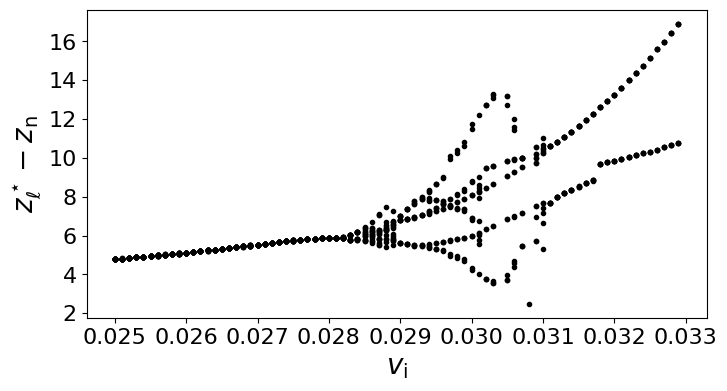

In [137]:

plt.figure(figsize=(8,4))
for i in range(v_i.size):
    h = results[i][0][int(0.5*timesteps.size):None]
    new_lens = results[i][1][int(0.5*timesteps.size):None]
    old_lens = np.roll(new_lens,-1)
    jumps = h[old_lens==1] - h[new_lens==1]
    plt.plot(v_i[i]*np.ones(h[old_lens==1].size),jumps,'o',markersize=3,color='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell^\star - z_\mathrm{n} $',fontsize=20)
plt.xlabel(r'$v_\mathrm{i}$',fontsize=20) 
# plt.ylim(3,12)
plt.show()
plt.close()

In [ ]:
h = results[-1][0][int(0.0*timesteps.size):None]

plt.plot(h,'ko')
plt.show()